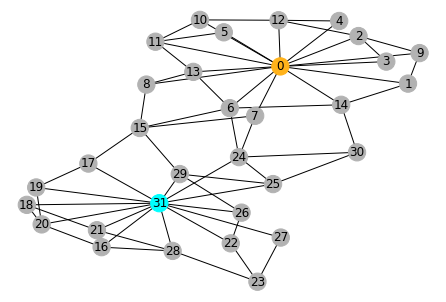

In [417]:
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import itertools
import matplotlib.pyplot as plt


def build_borrower_graph():

    src = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,31,31,31,31,31,31,31,31,31,31,31,31,22])
    dst = np.array([14,3,4,5,6,7,8,9,10,11,12,13,2,1,16,17,18,19,20,21,22,24,25,26,27,28,29,26])
    
    noise_s = np.array([1,15,15,12,11,11,18,30,25,20,21,26,29,14,8,17,19,20,28,27,2,23,2,28,9,6,30,25,6,15,7,6,10,14,15,13])
    noise_d = np.array([9,7,6,4,5,10,21,25,24,16,28,29,15,30,13,19,20,18,23,23,3,22,12,16,2,14,24,29,24,17,24,13,12,1,8,11])
    
    u = np.concatenate([src, noise_s])
    v = np.concatenate([dst, noise_d])
    
    return dgl.DGLGraph((u, v))

G = build_borrower_graph()
G = dgl.add_self_loop(G)

nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

codes = torch.tensor([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2])
colors = torch.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1]])

nx.draw(nx_G, pos, with_labels=True, node_color=colors[codes])

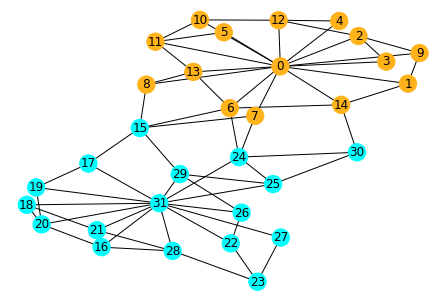

In [420]:
nx.draw(nx_G, pos, with_labels=True, node_color=colors[torch.argmax(logp,1)])

In [418]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

net = GCN(5, 5, 10)

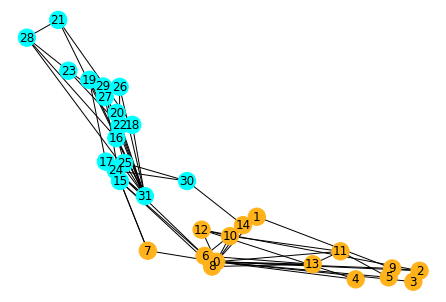

In [419]:
embed = nn.Embedding(32, 5)
G.ndata['feat'] = embed.weight
#G.ndata['feat'] = torch.randn((32, 5), requires_grad=True)
#print("embed.weight: ",embed.weight)

labeled_nodes = torch.tensor([0, 31])
#labels = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
labels = torch.tensor([0,1])

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
for epoch in range(50):
    logits = net(G, G.ndata['feat'])
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
colors = torch.tensor([[1,.7,.1],[0,1,1]])
nx.draw(nx_G.to_undirected(), logits.detach().numpy(), with_labels=True, node_color=colors[torch.argmax(logp,1)])

In [406]:
embed.para

Parameter containing:
tensor([[ 4.1448e-01, -5.0206e-01,  2.2992e+00, -8.7483e-01,  1.7075e+00],
        [-1.5458e-01, -1.0797e+00, -9.0351e-01,  7.3352e-01, -9.8549e-01],
        [ 7.8011e-01, -1.4383e+00,  8.9688e-01,  6.7219e-01,  1.1075e+00],
        [-2.0768e-01,  1.9376e+00,  4.0519e-02,  1.5566e+00,  1.3101e+00],
        [ 5.7776e-01, -1.9393e-01, -1.1504e+00,  2.4098e-01,  5.1412e-01],
        [ 4.7200e-01, -1.3182e+00,  1.6984e+00,  5.1458e-01,  1.3533e+00],
        [ 7.2323e-01,  1.1171e+00, -5.1897e-01,  1.0997e+00,  4.9257e-01],
        [-1.1822e+00,  5.1897e-01, -1.3099e+00,  2.1121e+00,  1.0487e+00],
        [-7.6625e-01,  4.6886e-01,  1.2421e+00, -1.2849e+00,  1.2283e+00],
        [ 9.2201e-01, -2.9598e-01, -9.0760e-01, -4.5070e-01, -4.0666e-01],
        [ 1.9110e+00,  1.7616e+00, -1.4390e+00,  5.0581e-01,  2.3241e-01],
        [-2.0352e+00, -7.5476e-01,  1.1534e+00,  3.5815e-01,  4.1368e-01],
        [-9.7992e-01,  3.4414e-01,  8.2348e-01, -6.0003e-01, -3.1915e-01],
   

In [423]:
embed.parameters

<bound method Module.parameters of Embedding(32, 5)>